# Drift normalized by observing frequency vs. Burst Duration

results/frb121102_michilli_dmvariations.csv
results/gajjar11a_dmvariations_oct15_2021.csv
results/dmvars_180916.csv
results/dmvars_180814.csv
results/FRB180301_DM516-518-5_luo_272rows_Aug21.csv
results/FRB121102_oostrum_525rows_Aug28.csv
results/FRB121102_aggarwal_results_1078rows_Nov22.csv
results/GajjarFRB121102_results_506rows_Oct19.csv
results/simulated_nov15.csv

# FRB20121102A Michilli et al. (2018):
>> num bursts remaining = 14

# FRB20121102A 11A Gajjar et al. (2018):
>> num bursts remaining = 2

# FRB20180916B bursts:
>> num bursts remaining = 16

# FRB20180814A bursts:
>> num bursts remaining = 6

# FRB20180301A bursts:
>> num bursts remaining = 15

# FRB20121102A Oostrum et al. (2020):
>> num bursts remaining = 23

# FRB20121102A Aggarwal et al. (2021):
>> num bursts remaining = 43

# FRB20121102A Gajjar et al. (2018):
>> num bursts remaining = 21
len(fig1pltdata['frames']) = 8, len(sources) = 9
FRB20121102A Michilli et al. (2018) (0.050 - 0.133) $t_w^{-1}$
FRB20121102A 11A 

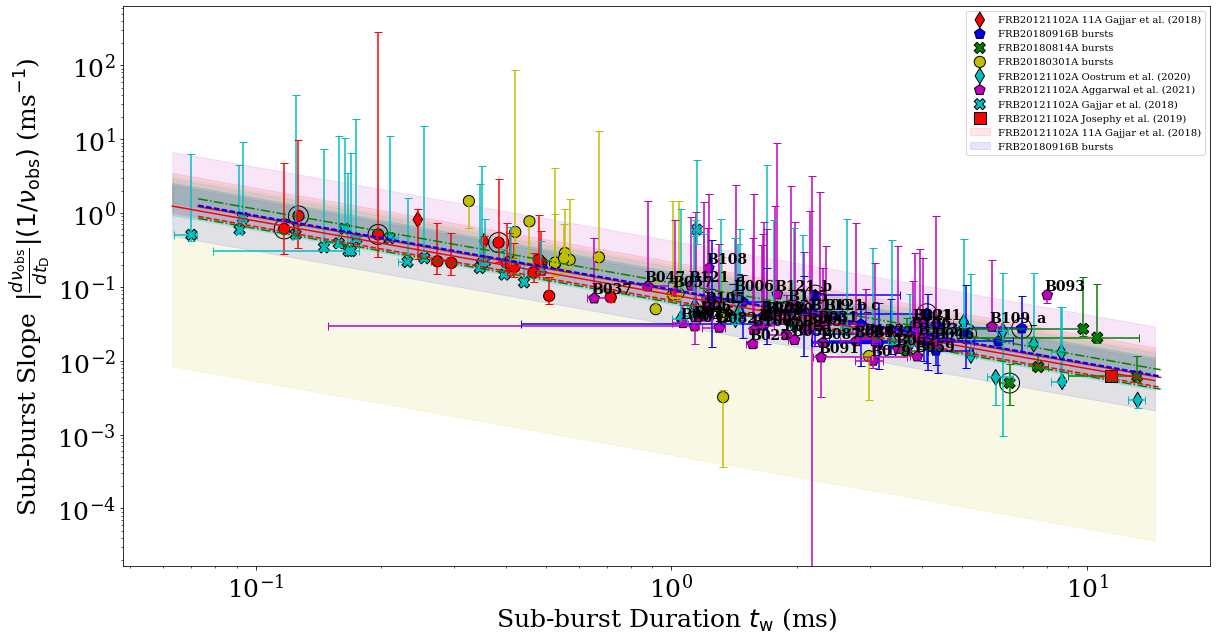

In [1]:
from frbrepeaters import driftlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
import scipy
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
%matplotlib inline

sources_filenames = [
    "results/frb121102_michilli_dmvariations.csv",
    'results/gajjar11a_dmvariations_oct15_2021.csv',
    'results/dmvars_180916.csv',
    'results/dmvars_180814.csv',
    'results/FRB180301_DM516-518-5_luo_272rows_Aug21.csv',
    'results/FRB121102_oostrum_525rows_Aug28.csv',
    'results/FRB121102_aggarwal_results_1078rows_Nov22.csv',
    'results/GajjarFRB121102_results_506rows_Oct19.csv',
    'results/simulated_nov15.csv'
]

sources = []
for sfile in sources_filenames:
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    print(sfile)
    df = driftlaw.computeModelDetails(df)
    sources.append(df)

names = [
    'FRB20121102A Michilli et al. (2018) DM Variations', 
    'FRB20121102A 11A Gajjar et al. (2018) DM Variations', 
    'FRB20180916B bursts DM Variations', 
    'FRB20180814A bursts DM Variations',
    'FRB20180301A bursts DM Variations',
    'FRB20121102A Oostrum et al. (2020) DM Variations',
    'FRB20121102A Aggarwal et al. (2021) DM Variations',
    'FRB20121102A Gajjar et al. (2018) DM Variations',
    'Simulated DM Variations'
]
annotations = [
    [0, 1, 2, 3, 4, 5],
    [],
    [3],
    [0, 1, 2, 3, 4, 5],
    [0, 1, 2, 3, 4, 5],
    [],
    # [],
    [],
    []
]
dmlimited = [
    [3, 5, 6, 14],
    [],
    [15.5, 16, 23, 24, 29, 31, 32, 33],
    [180919.0],
    [],
    [],
    [],
    [],
    []
]
exclusions = [
    [],
    [],
    [],
    [180917.0], # first is a multi burst, second has negative drift (which should better be corrected by limiting 180814's DM range)
    [],
    [],
    ['B023', 'B016', 'B028', 'B056', 'B109'],
    [],
    []
]

targetDMs   = [
    558.816263157895, 
    568.333333333333, 
    348.82, 
    188.8, 
    516.3571428571429, 
    560.526315789474,
    560,
    556,
    565
] 

def exclusionLogger(exclusionstr, frame):
    return # short 
    print(exclusionstr)
    count = 0
    if frame.empty:
        print(">> bursts excluded: \n\tnone")
    else:
        print('>> bursts excluded:', *[f"\n\t{exname} DM = {row['DM']}" for exname, row in frame.iterrows()])
        count += len(frame)
    print(f'>> # of measurements excluded: {count}')
    print(f'>> # of bursts limited: {len(frame.index.unique())}')
    return count

def DMrangeLogger(sname, frame, burstwise=False):
    return # short 
    if not burstwise:
        if type(frame) == pd.core.series.Series:
            print(f"{sname}\tDM Range: {frame[0]} pc/cm3")
        else:
            print(f"{sname}\t DM Range: {min(frame['DM'])} - {max(frame['DM'])} pc/cm3")
    else:
        print(f'>>> {sname} DM Range by burst:')
        for bname in frame.index.unique():
            DMrangeLogger(f'\tburst {bname}:', frame.loc[bname])
    return

def getFRB20121102AFit(pltdata):
    """ merge michilli and gajjar and fit together"""
    frb121102frame = pd.concat([pltdata['frames'][0],pltdata['frames'][1]])
    _, fits = driftlaw.plotSlopeVsDuration([frb121102frame], ['merged'], logscale=True, fiterrorfunc=driftlaw.log_error)
    return fits[0][1], fits[0][2]

fig1pltdata = { 'frames': [], 'labels': [], 'colors': cycle(['r', 'r', 'b', 'g', 'y', 'c', 'm', 'c']) }
fitdata = pd.DataFrame()
Bconstants = []
for source, name, annotate, exclude, targetDM in zip(sources, names, annotations, exclusions, targetDMs):
    frames = []
    labels = []
    
    print('\n#', name.split(' DM')[0]+':')
    DMrangeLogger('', source)
    source = source.drop(exclude)

    ## Burst Exclusions
    # exclude bursts that where a fit was not found
    exclusionLogger('> exclusion rule: no fit found', source[~(source.amplitude > 0)])
    source = source[source.amplitude > 0]
       
    # exclude positive drifts, we assume they are non-physical and an artifact of over dedispersion
    exclusionLogger('> exclusion rule: slope_abs < 0', source[~(source.slope_abs > 0)])
    source = source[source.slope_abs > 0] 

    # exclude slopes with large relative errors
    relerrthreshold = 0.4 # (40%)
    exclusionLogger(f'> exclusion rule: rel slope error > {relerrthreshold}', source[~(abs(source['slope error (mhz/ms)']/source['slope (mhz/ms)']) < relerrthreshold)])
    source = source[abs(source['slope error (mhz/ms)']/source['slope (mhz/ms)']) < relerrthreshold]
    
    # exclude slopes with huge errors, they are vertical and poorly measured
    errorthreshold = 1e8
    exclusionLogger('> exclusion rule: slope error > {}'.format(errorthreshold), source[~(source['slope error (mhz/ms)'] < errorthreshold)])
    source = source[source['slope error (mhz/ms)'] < errorthreshold] 
    
    DMrangeLogger(name.split(' DM')[0], source, burstwise=True) # log the dm range after we're done excluding
    source = driftlaw.sloperanges(source) # compute drift ranges after burst exclusions

    # special case: exclude 180911 at 190 pc/cm3 cuz drift range switches sign
    # TODO remove in favor of relative error (see above)
    # or exclude if 'slope_nu_minus' is negative but the other way seems more flexible
    if name == names[3]:
        source = source[~((source.DM == 190) & (source.slope_nu_min < 0))]
    source = driftlaw.sloperanges(source) # recompute range 

    for dm, color in zip(source.DM.unique(), cycle(['r', 'y', 'b', 'k', 'g', 'c', 'm'])):
        df = source[source.DM == dm]
        df['color'] = color
        frames.append(df)
        labels.append(dm)
        
        # Figure 1
        if np.isclose(dm, targetDM):
            print(f'>> num bursts remaining = {len(df.index.unique())}')
            df['color'] = next(fig1pltdata['colors'])
            fig1pltdata['frames'].append(df)
            fig1pltdata['labels'].append(name.split(' DM')[0])
            
        # For Ref figure A, turn off otherwise
        # if dm == 565:
        #     df['color'] = 'b'
        # if dm == 348.82:
        #     df['color'] = 'r'
            
        # Figure 5: compute drift/nu^2 vs nu range of fits
        nus = np.linspace(0, 20000, num=2000)   
        popt, pcov = scipy.optimize.curve_fit(lambda x, c: c, nus, df['slope_abs_nuobssq'])
        Bconstants.append((popt[0], np.sqrt(pcov[0])))
        
    # driftlaw.plotSlopeVsDuration(frames, labels, title=name, annotatei=annotate, logscale=True)
    markcolors = []
    for f in frames: 
        markcolors.append(f['color'].iloc[0])
    markcolors = cycle(markcolors)
    # manylines = ['r--', 'y-', 'b-.', 'k--', 'g--', 'c-.', 'r-', 'b-', 'k-', 'g-', 'c-']
    linestyles = ['--', '-', '-.', '--', '--', '-.', '-', '-', '-', '-', '-']
    manylines = [next(markcolors)+lst for lst in linestyles]
    labels = [round(lbl, 2) for lbl in labels]
    tempax, fits = driftlaw.plotSlopeVsDuration(frames, labels, annotatei=[], fitlines=manylines, logscale=True, fiterrorfunc=driftlaw.log_error, dmtrace=True, hidefitlabel=True)
    if name.split(' DM')[0] == 'FRB20180916B bursts':
        hdls, lbls = tempax.get_legend_handles_labels()
        order = [2, 1, 0, 3, 4]
        tempax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
    if name.split(' DM')[0] == 'FRB20121102A Gajjar et al. (2018)':
        tempax.set_xlim(0.073, 0.389)
        tempax.legend(fontsize='x-large', loc=1)
    
    for fit in fits:
        fitdata = fitdata.append({'name': name.split(' DM')[0], 
                                  'DM': fit[0], 
                                  'param': fit[1], 
                                  'err': fit[2] ,
                                  'red_chisq': fit[3], 
                                  'numbursts': fit[5]},
                                  ignore_index=True)

plt.close('all')

# fig1pltdata['frames'][0] = pd.concat([fig1pltdata['frames'][0], fig1pltdata['frames'][1]])
# del fig1pltdata['frames'][1]
# del fig1pltdata['labels'][1]
annotatei = [6]
ax, _ = driftlaw.plotSlopeVsDuration(fig1pltdata['frames'], fig1pltdata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.'], markers=['o', 'd', 'p', 'X'], title=None, 
                                     annotatei=annotatei, fitextents=[0.0728, 15], hidefit=[0, 1],
                                     logscale=True, errorfunc=driftlaw.rangeerror, fiterrorfunc=driftlaw.log_error)

## Mark all bursts whose DM ranges were limited by the exclusion process
print(f"{len(fig1pltdata['frames']) = }, {len(sources) = }")
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        # print('YOO: ', i, limitedpoints, lp)
        # print(fig1pltdata['frames'][i].head())
        v = fig1pltdata['frames'][i].loc[lp]
        plt.scatter(v['tau_w_ms'], v['slope_over_nuobs'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['slope_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

# see Josephy et al. 2019        
C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 11.4, 11.4/1000, 0.12, 1]
josephyburst = pd.DataFrame([C1data], columns=['name', 'angle', 'sigmax', 'sigmay', 'slope (mhz/ms)', 'slope error (mhz/ms)', 'center_f', 'time_res', 'freq_res', 'tau_w_ms', 'tau_w', 'tau_w_error', 'red_chisq']).set_index('name')
josephyburst['slope_over_nuobs'] = -1*josephyburst['slope (mhz/ms)']/josephyburst['center_f']
xerr, yerr = driftlaw.modelerror(josephyburst)
ax.scatter(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')
ax.errorbar(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], xerr=xerr[0], yerr=yerr[0], ecolor='r')

# Plot shaded regions
alldata = pd.concat([f for f in fig1pltdata['frames']+[josephyburst]])
x = np.linspace(min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1, num=1200)
# plt.rcParams['hatch.linewidth'] = 1
for name, color, hatch in zip(fitdata.name.unique(), fig1pltdata['colors'], ['', '/', '\\', '-', '', '', '', '']):
    params = fitdata.loc[(fitdata.name == name) & (fitdata.numbursts > 1.0)]['param']
    print(f"{name} ({min(params):.3f} - {max(params):.3f}) $t_w^{{-1}}$")
    if 'Michilli' not in name: # michilli region is contained in gajjar region so no need to plot it
        lstr = f"{name.split(' ')[0]} range of fits"
        lstr = name
        ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)
        # ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color='None', edgecolor='w', hatch=hatch, zorder=-9)

## Combine michilli and gajjar fits. See `getFRB20121102AFit()`. the result of the fit when merging frames is 0.083 +- 0.005
# frb121102_A = getFRB20121102AFit(fig1pltdata) # opens a figure
frb121102_A = (0.07816130353202802, 0.005971946986254264)
plt.plot(x, frb121102_A[0]/x, 'r-', label='{} fit ({:.3f} $\\pm$ {:.3f}) $t_w^{{-1}}$'.format('FRB20121102A', frb121102_A[0], frb121102_A[1]))

# Legend stuff
hdls, lbls = ax.get_legend_handles_labels()
# order = [3, 4, 7, 5, 6, 2, 0, 1, 8, 9, 10]
# ax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
# hdls[0], hdls[1], hdls[2], hdls[5], hdls[6], hdls[7] = hdls[2], hdls[0], hdls[1], hdls[7], hdls[5], hdls[6]
# lbls[0], lbls[1], lbls[2], lbls[5], lbls[6], lbls[7] = lbls[2], lbls[0], lbls[1], lbls[7], lbls[5], lbls[6]
# ax.legend(fontsize='medium')
ax.legend(hdls[8:18], lbls[8:18], fontsize='medium')
# ax.get_legend().remove()

# ax.set_xlim(0.0737, 12.5)
# ax.set_ylim(0.0013395279509532563, 508.64764364084175)
# plt.savefig('figures/driftvnuobs_dmvars.pdf')

In [12]:
source[['slope (mhz/ms)', 'tau_w_ms', 'slope error (mhz/ms)', 'tw_min', 'tw_max', 'tau_w_error']]

,slope (mhz/ms),tau_w_ms,slope error (mhz/ms),tw_min,tw_max,tau_w_error
name,,,,,,
11A,-705.035920,0.467270,0.037215,0.454111,0.677465,0.000053
11A,-722.334547,0.477174,0.038338,0.454111,0.677465,0.000053
11A,-738.261838,0.485584,0.039577,0.454111,0.677465,0.000054
11A,-753.971016,0.495960,0.041599,0.454111,0.677465,0.000055
11A,-756.407102,0.498027,0.041871,0.454111,0.677465,0.000055
11A,-771.470573,0.508199,0.043286,0.454111,0.677465,0.000056
11A,-790.242463,0.519359,0.046269,0.454111,0.677465,0.000058
11A,-809.132489,0.532268,0.048476,0.454111,0.677465,0.000059
11A,-832.400714,0.546107,0.051047,0.454111,0.677465,0.000060


In [7]:
for name in fitdata.name.unique():
    df = fitdata.loc[(fitdata.name == name)]# & (fitdata.numbursts > 1.0)]
    df = df.set_index('DM')
    display(df)
    # print('minimal standard deviation:')
    # display(df[df.err == df.err.min()])
    print('minimal red_chisq:')
    display(df[df.red_chisq == df.red_chisq.min()])
    
# dm at which chisq is minimal and no bursts entirely excluded
# michilli 559.405421
# gajjar   565.0
# 180916   346.82 (or 348.82 if picking for close to 1)
# 180814   188.9

,name,param,err,red_chisq,numbursts
DM,,,,,
554.10,FRB20121102A Michilli et al. (2018),0.050158,0.004069,136733.552395,14.0
554.69,FRB20121102A Michilli et al. (2018),0.052501,0.004161,113114.495784,14.0
555.28,FRB20121102A Michilli et al. (2018),0.055074,0.004275,89422.555439,14.0
555.87,FRB20121102A Michilli et al. (2018),0.057947,0.004645,76925.879224,13.0
556.46,FRB20121102A Michilli et al. (2018),0.060830,0.004670,55890.270226,14.0
557.05,FRB20121102A Michilli et al. (2018),0.064214,0.004986,42491.426906,14.0
557.64,FRB20121102A Michilli et al. (2018),0.067820,0.005429,33967.374134,14.0
558.23,FRB20121102A Michilli et al. (2018),0.071771,0.006000,28630.884037,14.0
558.82,FRB20121102A Michilli et al. (2018),0.076383,0.006840,26339.448829,14.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
558.82,FRB20121102A Michilli et al. (2018),0.076383,0.00684,26339.448829,14.0


,name,param,err,red_chisq,numbursts
DM,,,,,
555.00,FRB20121102A 11A Gajjar et al. (2018),0.062512,0.006961,8094.055488,5.0
556.67,FRB20121102A 11A Gajjar et al. (2018),0.067688,0.005284,2085.490447,5.0
558.33,FRB20121102A 11A Gajjar et al. (2018),0.083914,0.006818,1283.455742,5.0
560.00,FRB20121102A 11A Gajjar et al. (2018),0.099270,0.017929,3964.927923,5.0
561.67,FRB20121102A 11A Gajjar et al. (2018),0.122389,0.025446,6731.076591,5.0
563.33,FRB20121102A 11A Gajjar et al. (2018),0.161316,0.057379,12077.668465,5.0
565.00,FRB20121102A 11A Gajjar et al. (2018),0.155949,0.060352,7210.951962,3.0
566.67,FRB20121102A 11A Gajjar et al. (2018),0.143252,0.011007,492.957732,2.0
568.33,FRB20121102A 11A Gajjar et al. (2018),0.173926,0.029343,1563.749164,2.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
566.67,FRB20121102A 11A Gajjar et al. (2018),0.143252,0.011007,492.957732,2.0


,name,param,err,red_chisq,numbursts
DM,,,,,
348.82,FRB20180916B bursts,0.092944,0.006290,0.066130,16.0
347.82,FRB20180916B bursts,0.045092,0.002795,0.046493,16.0
346.82,FRB20180916B bursts,0.030818,0.002350,0.027899,16.0
349.32,FRB20180916B bursts,0.150444,0.022646,14.860191,13.0
349.82,FRB20180916B bursts,0.117677,0.077418,176.455013,7.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
346.82,FRB20180916B bursts,0.030818,0.00235,0.027899,16.0


,name,param,err,red_chisq,numbursts
DM,,,,,
189.0,FRB20180814A bursts,0.127097,0.055684,0.087969,5.0
189.8,FRB20180814A bursts,0.160173,0.055004,0.284966,5.0
190.0,FRB20180814A bursts,0.159940,0.076118,0.399564,4.0
188.9,FRB20180814A bursts,0.095074,0.027100,0.025257,6.0
189.4,FRB20180814A bursts,0.149269,0.073319,0.092681,5.0
188.8,FRB20180814A bursts,0.113196,0.042294,0.050263,6.0
188.7,FRB20180814A bursts,0.086459,0.020815,0.021891,5.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
188.7,FRB20180814A bursts,0.086459,0.020815,0.021891,5.0


,name,param,err,red_chisq,numbursts
DM,,,,,
516.00,FRB20180301A bursts,0.072745,1.098324e-02,1.140165e+03,15.0
516.18,FRB20180301A bursts,0.077890,1.504871e-02,1.734213e+03,16.0
516.36,FRB20180301A bursts,0.089080,1.867802e-02,2.083389e+03,15.0
516.54,FRB20180301A bursts,0.094834,2.664512e-02,3.529777e+03,13.0
516.71,FRB20180301A bursts,0.101093,3.137075e-02,4.669800e+03,12.0
516.89,FRB20180301A bursts,0.105706,4.341555e-02,4.606669e+03,10.0
517.07,FRB20180301A bursts,0.116129,6.054371e-02,1.980664e+03,10.0
517.25,FRB20180301A bursts,0.096375,3.002578e-02,4.958999e+02,5.0
517.43,FRB20180301A bursts,0.000532,4.246119e-04,6.436476e+03,6.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
517.0,FRB20180301A bursts,0.199348,0.284968,44.803353,2.0


,name,param,err,red_chisq,numbursts
DM,,,,,
560.00,FRB20121102A Oostrum et al. (2020),0.059091,0.004008,0.230783,24.0
560.50,FRB20121102A Oostrum et al. (2020),0.065482,0.004603,0.281903,24.0
560.53,FRB20121102A Oostrum et al. (2020),0.065482,0.004603,0.281897,24.0
561.05,FRB20121102A Oostrum et al. (2020),0.074473,0.005685,0.401361,24.0
561.58,FRB20121102A Oostrum et al. (2020),0.078161,0.006235,0.494650,24.0
562.11,FRB20121102A Oostrum et al. (2020),0.084723,0.007438,0.758465,24.0
562.63,FRB20121102A Oostrum et al. (2020),0.091522,0.008108,1.321238,23.0
563.16,FRB20121102A Oostrum et al. (2020),0.102854,0.010393,2.458782,23.0
563.68,FRB20121102A Oostrum et al. (2020),0.117004,0.014394,4.717149,23.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
560.0,FRB20121102A Oostrum et al. (2020),0.059091,0.004008,0.230783,24.0


,name,param,err,red_chisq,numbursts
DM,,,,,
560.00,FRB20121102A Aggarwal et al. (2021),7.793267,1.050858,2.536694e+06,25.0
560.50,FRB20121102A Aggarwal et al. (2021),8.740926,0.800906,2.491190e+06,25.0
561.00,FRB20121102A Aggarwal et al. (2021),9.030845,0.804304,8.777324e+08,28.0
561.50,FRB20121102A Aggarwal et al. (2021),9.540138,0.693237,2.566374e+06,28.0
562.00,FRB20121102A Aggarwal et al. (2021),9.512725,0.820705,2.171414e+06,28.0
562.06,FRB20121102A Aggarwal et al. (2021),2.414807,0.392252,1.491052e+05,6.0
562.50,FRB20121102A Aggarwal et al. (2021),11.189338,0.832202,1.851081e+06,24.0
563.00,FRB20121102A Aggarwal et al. (2021),12.177877,1.071755,4.032372e+06,25.0
563.50,FRB20121102A Aggarwal et al. (2021),14.586580,1.485796,5.902097e+06,24.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
565.3,FRB20121102A Aggarwal et al. (2021),8.312702,1.44057,11926.333794,5.0


,name,param,err,red_chisq,numbursts
DM,,,,,
555.00,FRB20121102A Gajjar et al. (2018),0.058412,0.004294,3.838948e+03,21.0
556.00,FRB20121102A Gajjar et al. (2018),0.061611,0.004381,3.507632e+03,21.0
557.00,FRB20121102A Gajjar et al. (2018),0.065171,0.005433,4.840306e+03,21.0
557.91,FRB20121102A Gajjar et al. (2018),0.069453,0.005697,3.578972e+03,21.0
558.00,FRB20121102A Gajjar et al. (2018),0.069453,0.005697,3.578972e+03,21.0
559.00,FRB20121102A Gajjar et al. (2018),0.076841,0.007078,3.130367e+03,21.0
560.00,FRB20121102A Gajjar et al. (2018),0.082436,0.008509,4.081979e+03,21.0
561.00,FRB20121102A Gajjar et al. (2018),0.087715,0.009475,4.872552e+03,21.0
562.00,FRB20121102A Gajjar et al. (2018),0.097214,0.013251,5.900057e+03,21.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
559.0,FRB20121102A Gajjar et al. (2018),0.076841,0.007078,3130.366942,21.0


,name,param,err,red_chisq,numbursts
DM,,,,,
560.0,Simulated,0.053642,0.004811,241.949673,3.0
561.0,Simulated,0.055679,0.004963,272.146239,3.0
562.0,Simulated,0.057957,0.005203,325.798912,3.0
563.0,Simulated,0.060023,0.004825,253.138488,3.0
564.0,Simulated,0.062094,0.004190,189.291544,3.0
565.0,Simulated,0.064922,0.003885,117.522702,3.0
566.0,Simulated,0.068058,0.003594,58.075881,3.0
567.0,Simulated,0.070666,0.002568,24.112898,3.0
568.0,Simulated,0.073635,0.001726,3.490536,3.0


minimal red_chisq:


,name,param,err,red_chisq,numbursts
DM,,,,,
568.0,Simulated,0.073635,0.001726,3.490536,3.0


# Drift vs. Frequency (Discussion Figure)

In [4]:
Bfits = np.array(Bconstants)
print(Bfits[:,0].min(), Bfits[:,0].max())
Bfits

<ipython-input-4-18217543ed36>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Bfits = np.array(Bconstants)


2.078964601744387e-08 3.501656829509886e-06


array([[3.755319457097987e-08, array([4.62947829e-09])],
       [3.958180525027664e-08, array([5.0959902e-09])],
       [4.186004466660003e-08, array([5.6489454e-09])],
       [4.5082972650862676e-08, array([6.80620332e-09])],
       [4.758091700090433e-08, array([7.14720958e-09])],
       [5.124433656779428e-08, array([8.19180507e-09])],
       [5.550334322804194e-08, array([9.5303914e-09])],
       [6.056955240732434e-08, array([1.12315229e-08])],
       [6.741532716456259e-08, array([1.37664844e-08])],
       [7.603638541932202e-08, array([1.74761348e-08])],
       [9.068450727638977e-08, array([2.44005783e-08])],
       [1.1731959437042582e-07, array([4.16298612e-08])],
       [2.3694669910297258e-07, array([1.44999377e-07])],
       [1.2132157911508368e-07, array([4.03948839e-08])],
       [1.7911307842075265e-07, array([7.9283062e-08])],
       [1.5651949767466468e-07, array([7.17765978e-08])],
       [3.501656829509886e-06, array([3.38884067e-06])],
       [2.1501480077554237e-0

6.590426024179991e-08 8.446693232174064e-09


<ipython-input-7-a5f2cb9c7565>:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Bfits = np.array(Bconstants)


2.078964601744387e-08 3.501656829509886e-06


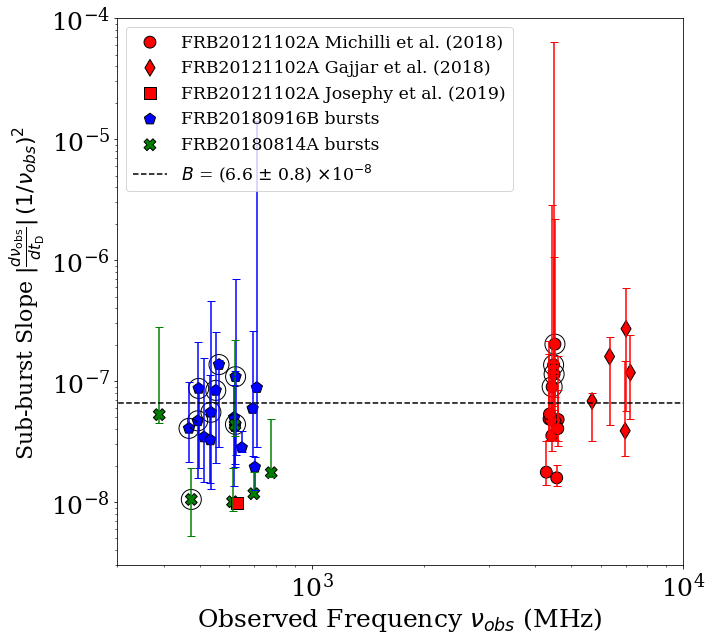

In [7]:
%matplotlib inline
def drift_nuobs_expr(B, x):
    return B[0]*x**2

def drift_nuobs_expr_log(B, x):
    return B[0] + 2*x

def constantmodel(x, c):
    return c

def drift_nuobs_sq(B, x):
    return B[0]*np.ones(x.shape)

def frexp10(x):
    """ 
    source : github.com/joelfrederico/SciSalt/blob/master/scisalt/numpy/frexp10.py 
    related: stackoverflow.com/questions/45332056/decompose-a-float-into-mantissa-and-exponent-in-base-10-without-strings 
    """
    expon = np.int(np.floor(np.log10(np.abs(x))))
    mant = x/np.power(10.0, expon)
    return (mant, expon)

plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 140
fontsize = 25
annotsize = 14
logscale = True
figsize = (10, 9)

frames = fig1pltdata['frames']
for frame in frames: 
    frame['drift_abs_nuobssq'] = frame['drift_abs']/frame['center_f']**2/1000
    
def yerror(frame):
    """ the shape of this is (1, 2, len(frame)) because pandas """
    ey = [np.array([frame['drift_abs_nuobssq'] - frame['drift_nu_min']/frame['center_f']/1000, frame['drift_nu_max']/frame['center_f']/1000 - frame['drift_abs_nuobssq']])]
    return ey

ax = frames[0].plot.scatter(x='center_f', y='drift_abs_nuobssq', 
                           # yerr=np.sqrt(frames[0]['red_chisq'])*frames[0]['drift error (mhz/ms)']*(1/frames[0]['center_f']**2)/1000,
                           yerr=yerror(frames[0]),
                           figsize=figsize, s=markersize, c='color', 
                           colorbar=False, fontsize=fontsize, 
                           logy=logscale, logx=logscale, marker='o', edgecolors='k',
                           label='FRB20121102A Michilli et al. (2018)')

labels = ['FRB20121102A Gajjar et al. (2018)', 'FRB20180916B bursts', 'FRB20180814A bursts']
for frame, label, mark in zip(frames[1:], labels, ['d', 'p', 'X']):
    frame.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                       # yerr=np.sqrt(frame['red_chisq'])*frame['drift error (mhz/ms)']*(1/frame['center_f']**2)/1000,
                       yerr=yerror(frame),
                       figsize=figsize, s=markersize, c='color', colorbar=False, 
                       fontsize=fontsize, logy=logscale, logx=logscale, marker=mark, edgecolors='k',
                       label=label)

# Josephy point
ax.scatter(josephyburst['center_f'], -josephyburst['drift (mhz/ms)']/josephyburst['center_f']**2/1000, c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')

## Mark all bursts whose DM ranges were limited by the exclusion process
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        v = fig1pltdata['frames'][i].loc[lp]
        plt.scatter(v['center_f'], v['drift_abs_nuobssq'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

ax.set_xlabel('Observed Frequency $\\nu_{obs}$ (MHz)', size=fontsize)
ax.set_ylabel('Sub-burst Slope $\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|\, (1/\\nu_{obs})^{2}$', size=fontsize-3)
alldata = pd.concat([f for f in fig1pltdata['frames']])#+[josephyburst]])

x = np.linspace(0, 20000, num=2000)   
popt, pcov = scipy.optimize.curve_fit(lambda x, c: c, x, alldata['drift_abs_nuobssq'])
berr = frexp10(np.sqrt(pcov[0][0]))[0]
hacklbl = f'$\it{{B}}$ = ({frexp10(popt[0])[0]:.2} $\pm$ {berr/10:.1}) $\\times$10$^{{{frexp10(popt[0])[1]}}}$'
# hacklbl = '($B = 6.7 \\times 10^{-8}$)'
plt.plot(x, popt[0]*np.ones(x.shape), 'k--', label=hacklbl)
print(popt[0], np.sqrt(pcov[0][0]))#, np.frexp(popt[0]))

# range of fits
Bfits = np.array(Bconstants)
color = 'b'
bmin, bmax = Bfits[:,0].min(), Bfits[:,0].max()
print(bmin, bmax)
lstr = f"Range of fits: {frexp10(bmin)[0]:.2}$\\times$10$^{{{frexp10(bmin)[1]}}}$ to {frexp10(bmax)[0]:.2}$\\times$10$^{{{frexp10(bmax)[1]}}}$"
lstr = "Range of possible fits"
# lstr = f"Range of fits {Bfits[:,0].min():.1e} - {Bfits[:,0].max():.1e}"
# ax.fill_between(x, Bfits[:,0].min(), Bfits[:,0].max(), alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)

hdls, lbls = ax.get_legend_handles_labels()
order = [1, 2, 5, 3, 4, 0]
hdls = [hdls[i] for i in order]
lbls = [lbls[i] for i in order]
ax.legend(hdls, lbls, fontsize='xx-large', loc=2)

plt.xlim(3*10**2, 10**4)
plt.ylim(0.3*10**-8, 1*10**-4)
plt.tight_layout()
plt.savefig('universal/driftvsnuobs_log.pdf')

Text(0.5, 0, 'Observed Frequency (MHz)')

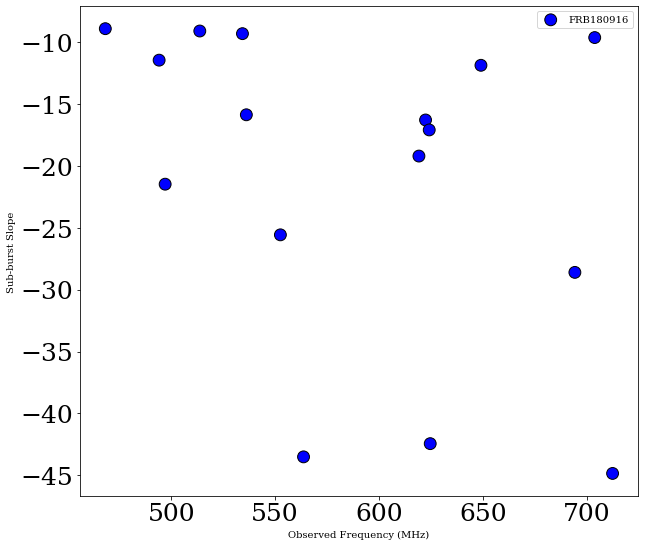

In [7]:
# sub-burst slope vs nu_obs to compare with pastor-marazuela et al. 2020
ax = frames[2].plot.scatter(x='center_f', y='drift (mhz/ms)', 
                           # yerr=np.sqrt(frames[0]['red_chisq'])*frames[0]['drift error (mhz/ms)']*(1/frames[0]['center_f']**2)/1000,
                           yerr=yerror(frames[2]),
                           figsize=figsize, s=markersize, c='color', 
                           colorbar=False, fontsize=fontsize, 
                           logy=False, logx=False, marker='o', edgecolors='k',
                           label='FRB180916')
ax.set_ylabel("Sub-burst Slope")
ax.set_xlabel("Observed Frequency (MHz)")

# Reference

<ipython-input-31-166b622dec7b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  michillibursts['drift_abs_z'] = michillibursts['drift_abs']*(1+michillibursts['z'])**2
<ipython-input-31-166b622dec7b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  michillibursts['drift_abs_nuobssq'] = michillibursts['drift_abs']*(1/michillibursts['center_f']**2)/1000
<ipython-input-31-166b622dec7b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

[8.22364449e-08] [1.73154499e-08]
[8.22364445e-08] [1.731545e-08]


<ipython-input-31-166b622dec7b>:112: RuntimeWarning: divide by zero encountered in log
  xlog = np.log(x)


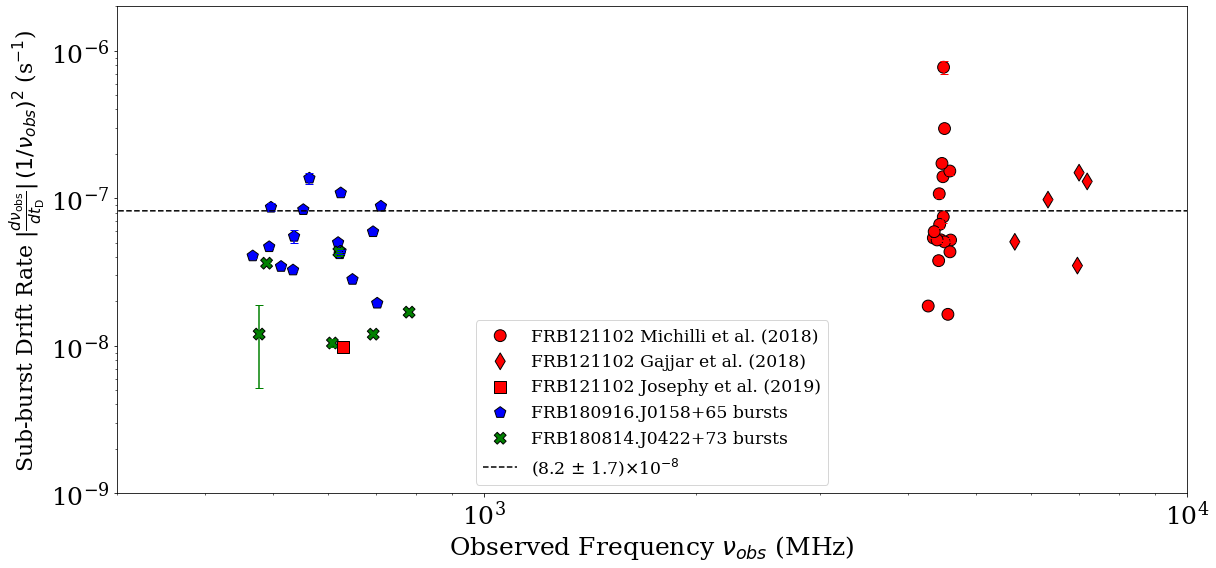

In [31]:
# michili fit
def drift_nuobs_expr(B, x):
    return B[0]*x**2

def drift_nuobs_expr_log(B, x):
    return B[0] + 2*x

def constantmodel(x, c):
    return c

def drift_nuobs_sq(B, x):
    return B[0]*np.ones(x.shape)

drift_nuobs_model = scipy.odr.Model(drift_nuobs_expr)
drift_nuobs_model_log = scipy.odr.Model(drift_nuobs_expr_log)
drift_nuobs_sq_model = scipy.odr.Model(drift_nuobs_sq)

plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 140
fontsize = 25
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration_inprep' if logscale else 'drift_over_nu_obsvsduration_inprep'
figsize = (17, 8)
# figsize = (14, 10)

michillibursts['drift_abs_z'] = michillibursts['drift_abs']*(1+michillibursts['z'])**2
michillibursts['drift_abs_nuobssq'] = michillibursts['drift_abs']*(1/michillibursts['center_f']**2)/1000
michillibursts['center_f_z'] = michillibursts['center_f']*(1+michillibursts['z'])

selectbursts180916['drift_abs_z'] = selectbursts180916['drift_abs']*(1+selectbursts180916['z'])**2
selectbursts180916['drift_abs_nuobssq'] = selectbursts180916['drift_abs']*(1/selectbursts180916['center_f']**2)/1000
selectbursts180916['center_f_z'] = selectbursts180916['center_f']*(1+selectbursts180916['z'])

selectbursts180814['drift_abs_z'] = selectbursts180814['drift_abs']*(1+selectbursts180814['z'])**2
selectbursts180814['drift_abs_nuobssq'] = selectbursts180814['drift_abs']*(1/selectbursts180814['center_f']**2)/1000
selectbursts180814['center_f_z'] = selectbursts180814['center_f']*(1+selectbursts180814['z'])

otherbursts['drift_abs_z'] = otherbursts['drift_abs']*(1+otherbursts['z'])**2
otherbursts['drift_abs_nuobssq'] = otherbursts['drift_abs']*(1/otherbursts['center_f']**2)/1000
otherbursts['center_f_z'] = otherbursts['center_f']*(1+otherbursts['z'])

ax = michillibursts.plot.scatter(x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']*(1/michillibursts['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']*(1/selectbursts180916['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']*(1/selectbursts180814['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', edgecolors='k', label='FRB121102 Gajjar et al. (2018)')
otherbursts.tail(1).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', edgecolors='k', label='FRB121102 Josephy et al. (2019)')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_abs'] > 0:
#         ax.annotate(k, (v['center_f'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

# if not logscale:
#     ax.set_xlim(-0.1, 20)
#     ax.set_ylim(-0.2, 4)
# elif logscale:
#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Observed Frequency $\\nu_{obs}$ (MHz)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|\, (1/\\nu_{obs})^{2}$ (s$^{-1}$)', size=fontsize-3)


allbursts = pd.concat([michillibursts, otherbursts, selectbursts180916, selectbursts180814])
### LINEAR FIT
fitbitch = scipy.odr.RealData(allbursts['center_f'], 
                             allbursts['drift_abs_nuobssq'])#,
                             #sy=np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']*(1/allbursts['center_f']**2)/1000,
                             #sx=np.array(len(allbursts['center_f'])*[5000])*np.random.rand(len(allbursts['center_f'])))
fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_sq_model, beta0=[0.00003])
fitter_driftnuobs.set_job(fit_type=0)
fitdriftnuobs = fitter_driftnuobs.run()

### LOG FIT
# fitbitch = scipy.odr.RealData(np.log(allbursts['center_f']), 
#                              np.log(allbursts['drift_abs']))
#                              #sy=np.log(np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']))
# fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_model_log, beta0=[1000])
# fitter_driftnuobs.set_job(fit_type=0)
# fitdriftnuobs = fitter_driftnuobs.run()

x = np.linspace(0, 20000, num=2000)   
popt, pcov = scipy.optimize.curve_fit(constantmodel, x, allbursts['drift_abs_nuobssq'])#, 
                                      #sigma=np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']*(1/allbursts['center_f']**2)/1000, 
                                      #absolute_sigma=True)
print(popt, np.sqrt(pcov)[0])
### Plot fits
xlog = np.log(x)
print(fitdriftnuobs.beta, fitdriftnuobs.sd_beta)

hacklbl = '(8.2 $\pm$ 1.7)$\\times$10$^{-8}$'
lbl = '({:.1e} $\pm$ {:0.2e})'.format(fitdriftnuobs.beta[0], fitdriftnuobs.sd_beta[0])
#plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
# plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
plt.plot(x, popt[0]*np.ones(x.shape), 'k--', label=hacklbl)
#plt.plot(x, fitdriftnuobs.beta[0]+2*x, l, label=str((round(fitdriftnuobs.beta[0], 6))) + ' $\\nu_{obs}^{2}$')

# plt.xlim(2*10**2, 1*10**4)
# plt.ylim(10**-1, 10**5)
# plt.xlim(0, 10000); plt.ylim(-500, 20000)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[4], handles[5], handles[2], handles[3], handles[0]]
labels = [labels[1], labels[4], labels[5], labels[2], labels[3], labels[0]]
plt.legend(handles, labels, fontsize='xx-large', loc=8)

###
plt.xlim(3*10**2, 10**4)
plt.ylim(10**-9, 2*10**-6)

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('driftvsnuobs_log.pdf')

# Pasted from other notebook, dont run

In [ ]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import driftlaw

bursts121102 = pd.read_csv('data/aggregate/burstsFRB121102.csv') 
bursts121102 = bursts121102.set_index('name')
##########
bursts180916 = pd.read_csv('data/aggregate/burstsFRB180916.csv') 
bursts180916 = bursts180916.set_index('name')
bursts180916['time_res'] = 0.00098304 # s
#########
bursts180814 = pd.read_csv('data/aggregate/burstsFRB180814.csv') # DM = 188.9 pc/cm3
bursts180814 = bursts180814.set_index('name')
bursts180814['time_res'] = 0.00098304 # s, Not true for burst 180917
###########
burstsSGR1935 = pd.read_csv('data/aggregate/SGR1935+2154bursts.csv')
burstsSGR1935 = burstsSGR1935.set_index('name')
##########

# Set redshifts
bursts121102['z']  = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z']  = 0.0337  # (chime 2020b et al.)
bursts180814['z']  = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)
burstsSGR1935['z'] = 0       # ? galactic

#######
bursts121102 = driftlaw.computeModelDetails(bursts121102)
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12
bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
selectbursts121102 = bursts121102.loc[bursts121102_to_include]

bursts180916 = driftlaw.computeModelDetails(bursts180916)
selectbursts180916 = bursts180916

bursts180814 = driftlaw.computeModelDetails(bursts180814)
selectbursts180814 = bursts180814.drop(180917)

burstsSGR1935 = driftlaw.computeModelDetails(burstsSGR1935)
#display(bursts121102[['tau_w', 'tau_w_error']], bursts180916[['tau_w', 'tau_w_error']], bursts180814[['tau_w', 'tau_w_error']], burstsSGR1935[['tau_w', 'tau_w_error']])

In [ ]:
fit_model = scipy.odr.Model(driftlaw.reciprocal_odr)
fit_model_log = scipy.odr.Model(driftlaw.reciprocal_odr_log)
# Color by source
selectbursts121102['color'] = 'r'#'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'r'#'b'
selectbursts180916['color']          = 'b'
selectbursts180814['color']          = 'g'
burstsSGR1935['color']               = 'k'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)
burstsSGR1935['drift (mhz/ms)']

In [ ]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 125#100
fontsize = 25 #18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration' if logscale else 'drift_over_nu_obsvsduration'
figsize = (17, 8)
figsize = (17, 9)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['tau_w_error'], 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize+50, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts')
                               #label='FRB180814.J0422+73 bursts @ DM={} pc/cm$^3$'.format(dms180814[dm_idx]))
burstsSGR1935.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['tau_w_error'], 
                               yerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['drift error (mhz/ms)']/burstsSGR1935['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='SGR1935+2154 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='FRB121102 Gajjar et al. (2018)') 
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='FRB121102 Josephy et al. (2019)') 

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in burstsSGR1935.iterrows():
    if v['drift_over_nuobs'] > 0 or not logscale:
        ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_over_nuobs'] > 0:
#         ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    pass
    # ax.set_xlim(-0.1, 20)
    # ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.04, 20)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,(1/\\nu_{\\mathrm{obs}}) \left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)', size=fontsize)

def driftnu_error(frame):
    sx = np.log((frame['tau_w_ms'] + np.sqrt(frame['red_chisq'])*frame['tau_w_error']) / frame['tau_w_ms'])
    sy = np.log((frame['drift_over_nuobs'] + np.sqrt(frame['red_chisq'])*(frame['drift error (mhz/ms)'])) / frame['drift_over_nuobs'])
    return sx, sy

# ODR fit log
num_to_fit = 24 #23 to exlude chime
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(num_to_fit)['tau_w_ms']), 
                             np.log(selectbursts121102.head(num_to_fit)['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts121102.head(num_to_fit))[0],
                             sy=driftnu_error(selectbursts121102.head(num_to_fit))[1])
                             #sx=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['drift error (mhz/ms)']/selectbursts121102.head(num_to_fit)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms']), 
                             np.log(selectbursts180916['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180916)[0],
                             sy=driftnu_error(selectbursts180916)[1])
                             #sx=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

# ODR fit log 180814
fitdata_log_180814 = scipy.odr.RealData(np.log(selectbursts180814['tau_w_ms']), 
                             np.log(selectbursts180814['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180814)[0],
                             sy=driftnu_error(selectbursts180814)[1])
                             #sx=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'] ))
odrfitter_log180814 = scipy.odr.ODR(fitdata_log_180814, fit_model_log, beta0=[1000])
odrfitter_log180814.set_job(fit_type=0)
odrfit_log180814 = odrfitter_log180814.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta), np.exp(odrfit_log180814.beta)]
errs  = [opts[0]*(np.exp(odrfit_log.sd_beta)-1), opts[1]*(np.exp(odrfit_log180916.sd_beta)-1), opts[2]*(np.exp(odrfit_log180814.sd_beta)-1)]
#errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta), np.exp(odrfit_log180814.sd_beta)]
#names = ['Fit from FRB121102 bursts', 'Fit from FRB180916.J0158+65 bursts', 'Fit from FRB180814.J0422+73 bursts']

names = ['FRB121102 fit', 'FRB180916.J0158+65 fit', 'FRB180814.J0422+73 fit']
ls    = ['r-', 'b--', 'g-.']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    lstr = '{} ({:.3f} $\pm$ {:.3f}) / $t_w$'.format(name, opt[0], err[0])
    plt.plot(x, opt[0]/x, l, label=lstr)

handles, labels = ax.get_legend_handles_labels()
#handles = [handles[0], handles[2], handles[4], handles[5], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[5], labels[1], labels[3]]
# handles = [handles[2], handles[5], handles[6], handles[4], handles[3], handles[0], handles[1]]
# labels = [labels[2], labels[5], labels[6], labels[4], labels[3], labels[0], labels[1]]
handles = [handles[3], handles[6], handles[7], handles[5], handles[4], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[6], labels[7], labels[5], labels[4], labels[0], labels[1], labels[2]]
plt.legend(handles, labels, fontsize='xx-large')
# 2 digits, ytitle

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('180814_dm{}.png'.format(dms180814[dm_idx]))
# print('180814_dm{}.png'.format(dms180814[dm_idx]))
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))
# for f in ['png']: plt.savefig('figures/{}.{}'.format(filename, f))